In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input, Reshape
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
!pip install numpy requests nlpaug
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

     |████████████████████████████████| 405 kB 4.4 MB/s eta 0:00:01


In [3]:
def dataframe_creation():
    col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
    df_4 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/train.tsv',header = None,sep='\t')
    df_4.columns =  col_list
    return df_4

df = dataframe_creation()
print(df.shape)
#df = df.drop(['Body ID'], axis=1)
le = preprocessing.LabelEncoder()
df.head()

(10240, 14)


,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [4]:
df.columns

Index(['Loc', 'Pred', 'Sent', 'Topic', 'Speaker', 'Position', 'Region',
       'Party', 'a', 'b', 'c', 'd', 'e', 'Occasion'],
      dtype='object')

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = df['Sent']
Y = df['Pred']
def maxlength(lt):
    maxi = 0
    for i in lt:
        maxi  = max(maxi, len(str(i).split()) )
    return maxi
max_len= maxlength(X)
max_len

467

In [6]:
df.groupby('Pred').count()

,Loc,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
Pred,,,,,,,,,,,,,
barely-true,1654,1654,1654,1654,1141,1300,1654,1654,1654,1654,1654,1654,1640
false,1995,1995,1993,1993,1435,1545,1993,1993,1993,1993,1993,1993,1972
half-true,2114,2114,2114,2114,1524,1674,2114,2114,2114,2114,2114,2114,2097
mostly-true,1962,1962,1962,1962,1471,1622,1962,1962,1962,1962,1962,1962,1945
pants-fire,839,839,839,839,503,524,839,839,839,839,839,839,828
true,1676,1676,1676,1676,1269,1367,1676,1676,1676,1676,1676,1676,1656


In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
balanced_df = df.groupby('Pred').apply(lambda x: x.sample(839)).reset_index(drop=True)
balanced_df['Sent'] = balanced_df['Sent'].astype(str)

In [8]:
balanced_df.groupby('Pred').count()

,Loc,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
Pred,,,,,,,,,,,,,
barely-true,839,839,839,839,581,655,839,839,839,839,839,839,830
false,839,839,838,838,604,644,838,838,838,838,838,838,826
half-true,839,839,839,839,605,674,839,839,839,839,839,839,832
mostly-true,839,839,839,839,634,690,839,839,839,839,839,839,831
pants-fire,839,839,839,839,503,524,839,839,839,839,839,839,828
true,839,839,839,839,634,674,839,839,839,839,839,839,833


In [9]:
balanced_df.head()

,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,11354.json,barely-true,"Weve had examples like in Yuma County, where w...",immigration,ben-carson,NaN,NaN,republican,7.0,12.0,3.0,2.0,4.0,"an interview on ABC's ""This Week"""
1,10489.json,barely-true,One Texas city has a law that says that women ...,"sexuality,states,supreme-court",alcee-hastings,U.S. Representative,Florida,democrat,1.0,0.0,1.0,0.0,2.0,an interview with CNN
2,12039.json,barely-true,Regarding her State Department email practices...,technology,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a Univision/Washington Post Democratic debate
3,8844.json,barely-true,We have been confronted with an unexpected sto...,weather,nathan-deal,NaN,NaN,republican,9.0,5.0,11.0,11.0,0.0,an interview
4,4635.json,barely-true,I dont think Ive ever hired an illegal in my l...,immigration,mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,a Republican presidential primary debate


In [10]:
balanced_df.shape

(5034, 14)

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
def filter(lt):
    nlt=[]
    i = 0
    for text in tqdm(lt):
        text = str(text)
        text_tokens = word_tokenize(text)
        tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
        filtered_sentence = (" ").join(tokens_without_sw)
        nlt.append(filtered_sentence)
    return nlt

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X = balanced_df['Sent']
Y = balanced_df['Pred']
X_f = filter(X)
max_len= maxlength(X)
max_len

In [12]:
df = pd.read_csv('../input/newsdatasets/Liar_Preprocessed.csv')
X = df['Sent']
Y = df['Pred']
max_len= maxlength(X)
print(max_len)
le.fit(Y)
Y = le.transform(Y)
num_classes=  len(le.classes_)
num_classes

65


6

In [13]:
def Convert(lst):
    res_dct = {i : lst[i] for i in range(0, len(lst))}
    return res_dct
classes = Convert(le.classes_)

# Transfer Learning

In [14]:
from tqdm.notebook import tqdm
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel,DistilBertTokenizer , RobertaTokenizer, TFRobertaModel
#dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
#robert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#robert_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
def data_creation(X,Y,token):
    input_ids=[]
    attention_masks=[]
    for sent in tqdm(X):
        dbert_inps=token.encode_plus(str(sent),add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    Y=np.array(Y)
    print(len(input_ids),len(attention_masks),len(Y))
    return input_ids,attention_masks,Y

In [20]:
model_use = bert_model
token_use = bert_tokenizer
input_ids,attention_masks,Y = data_creation(X,Y,token_use)

  0%|          | 0/5034 [00:00<?, ?it/s]

5034 5034 5034


In [21]:
from tensorflow.keras.layers import LSTM,add
from tensorflow.keras.layers import Flatten , Conv1D
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
def create_model(max_len,num_classes,mod):
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = mod(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dense = Reshape(( 256 , 16))(dense)
    head4 = Conv1D(36,5)(dense)
    head4 = MaxPooling1D(5,padding='same')(head4)
    head4 = Flatten()(head4)
    dropout= Dropout(0.5)(head4)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    return model

In [22]:
model = create_model(max_len,num_classes,model_use)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_bert_model[0][0]          

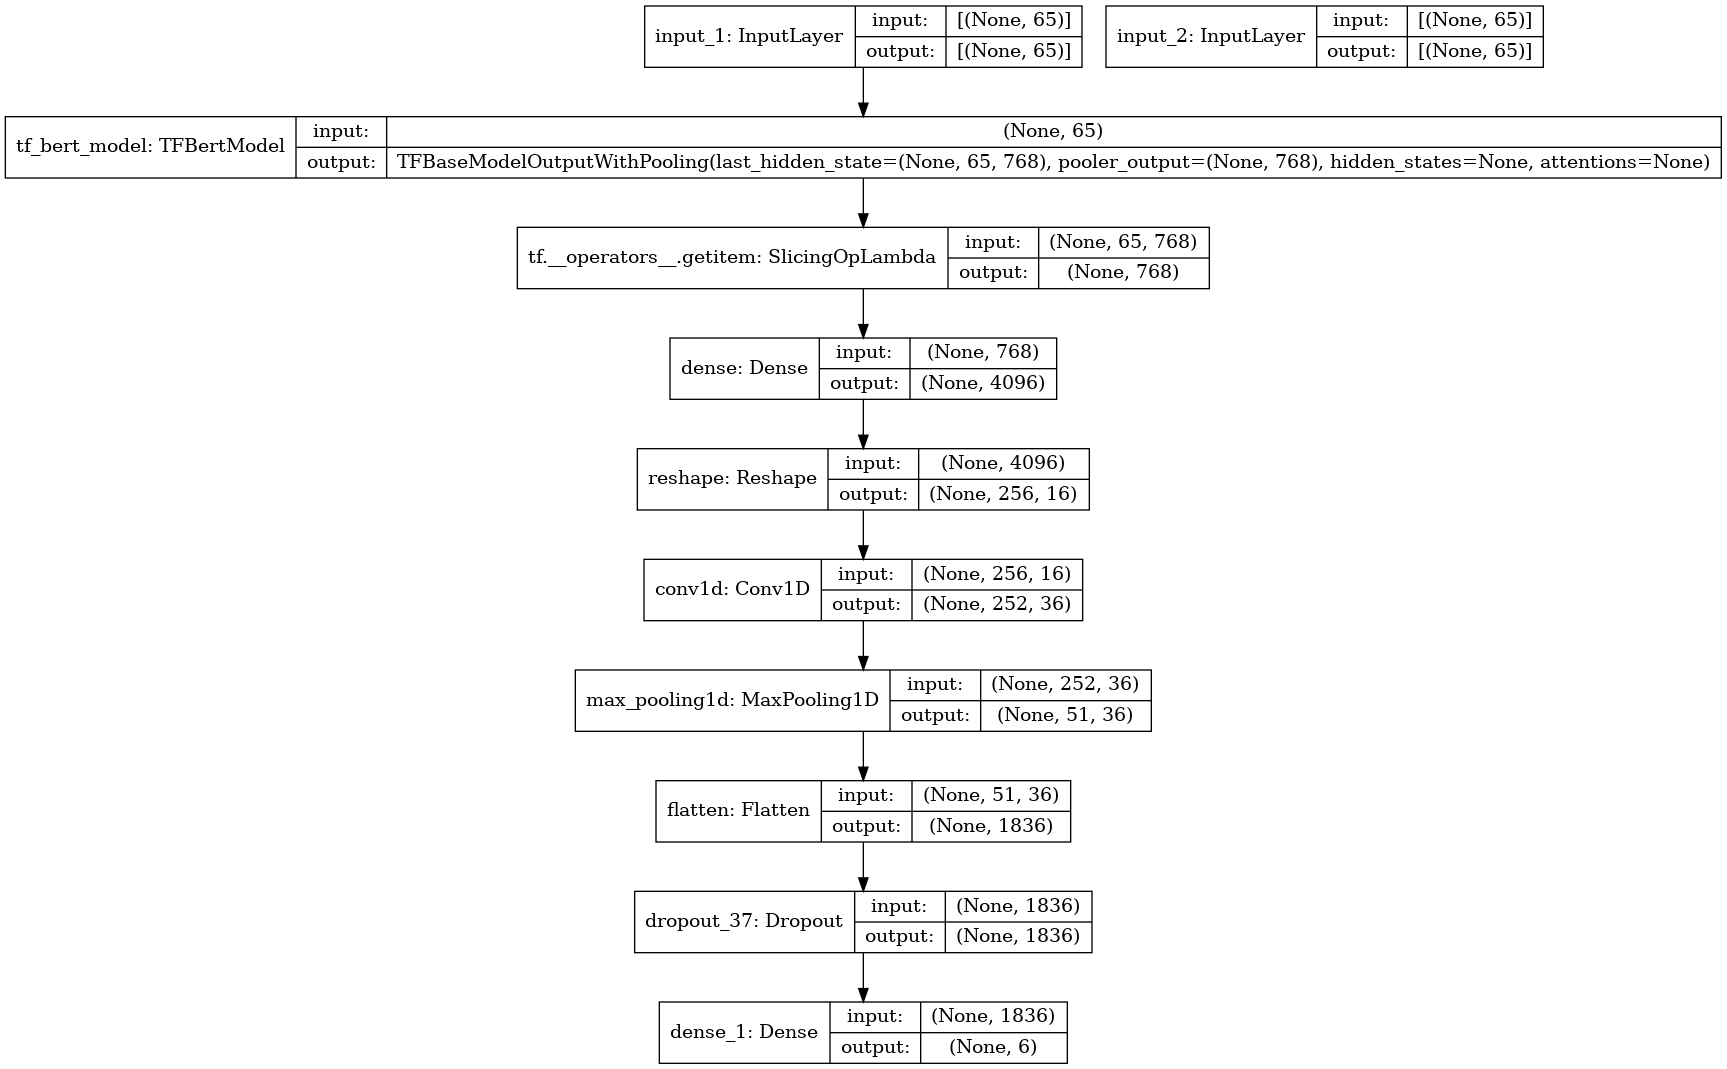

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [24]:
print('Preparing the pickle file.....')

pickle_inp_path='dbert_inp.pkl'
pickle_mask_path='dbert_mask.pkl'
pickle_Pred_path='dbert_Pred.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((Y),open(pickle_Pred_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_Pred_path)

Preparing the pickle file.....
Pickle files saved as  dbert_inp.pkl dbert_mask.pkl dbert_Pred.pkl


In [25]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
Preds=pickle.load(open(pickle_Pred_path, 'rb'))

print('Input shape {} Attention mask shape {} Input Pred shape {}'.format(input_ids.shape,attention_masks.shape,Preds.shape))

Loading the saved pickle files..
Input shape (5034, 65) Attention mask shape (5034, 65) Input Pred shape (5034,)


In [26]:
classes

{0: 'barely-true',
 1: 'false',
 2: 'half-true',
 3: 'mostly-true',
 4: 'pants-fire',
 5: 'true'}

In [27]:
Pred_class_dict=classes
target_names=Pred_class_dict.values()

In [28]:
train_inp,val_inp,train_Pred,val_Pred,train_mask,val_mask=train_test_split(input_ids,Preds,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain Pred shape {} Val Pred shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_Pred.shape,val_Pred.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model'
model_save_path='./dbert_model.h5'

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (4027, 65) Val input shape (1007, 65)
Train Pred shape (4027,) Val Pred shape (1007,)
Train attention mask shape (4027, 65) Val attention mask shape (1007, 65)


In [29]:
history=model.fit([input_ids,attention_masks],Preds,batch_size=64,epochs=10,validation_data=([val_inp,val_mask],val_Pred))

Epoch 1/10
79/79 [==============================] - 52s 591ms/step - loss: 14.4507 - accuracy: 0.1800 - val_loss: 13.1062 - val_accuracy: 0.3029
Epoch 2/10
79/79 [==============================] - 47s 590ms/step - loss: 12.7383 - accuracy: 0.2656 - val_loss: 11.5641 - val_accuracy: 0.3595
Epoch 3/10
79/79 [==============================] - 46s 587ms/step - loss: 11.2659 - accuracy: 0.3310 - val_loss: 10.1212 - val_accuracy: 0.5015
Epoch 4/10
79/79 [==============================] - 46s 588ms/step - loss: 9.8968 - accuracy: 0.4554 - val_loss: 8.8204 - val_accuracy: 0.6415
Epoch 5/10
79/79 [==============================] - 47s 591ms/step - loss: 8.6854 - accuracy: 0.5787 - val_loss: 7.6589 - val_accuracy: 0.7478
Epoch 6/10
79/79 [==============================] - 47s 590ms/step - loss: 7.5575 - accuracy: 0.7052 - val_loss: 6.7461 - val_accuracy: 0.8252
Epoch 7/10
79/79 [==============================] - 46s 588ms/step - loss: 6.6040 - accuracy: 0.8132 - val_loss: 5.8653 - val_accuracy: 

## Evaluation

In [30]:
preds = model.predict([val_inp,val_mask],batch_size=16)
pred_Preds = preds.argmax(axis=1)


In [31]:
target_names=le.classes_
#$print('F1 score',f1)
print('Classification Report')
print(classification_report(val_Pred,pred_Preds,target_names=target_names))

print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       1.00      0.99      0.99       162
       false       0.99      1.00      1.00       166
   half-true       1.00      0.98      0.99       164
 mostly-true       0.98      0.94      0.96       178
  pants-fire       1.00      1.00      1.00       157
        true       0.94      1.00      0.97       180

    accuracy                           0.98      1007
   macro avg       0.99      0.98      0.98      1007
weighted avg       0.98      0.98      0.98      1007

Training and saving built model.....


# Create Test from test data and remove non corpus words

In [32]:
col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
dfT = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/test.tsv',header = None,sep='\t')
dfT.columns =  col_list
dfT.head()

,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [44]:
Xt = dfT['Sent']
Yt = dfT['Pred']
Yt = le.transform(Yt)
def maxlength(lt):
    maxi = 0
    for i in lt:
        maxi  = max(maxi, len(str(i).split()) )
    return maxi


In [36]:
dfT.shape

(1267, 14)

In [38]:
input_idsT,attention_masksT,YT = data_creation(Xt,Yt,token_use)

  0%|          | 0/1267 [00:00<?, ?it/s]

1267 1267 1267


In [42]:
preds = model.predict([input_idsT,attention_masksT],batch_size=16)
pred_Preds = preds.argmax(axis=1)


In [43]:
target_names=le.classes_
#$print('F1 score',f1)
print('Classification Report')
print(classification_report(Yt,pred_Preds,target_names=target_names))

print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       1.00      0.99      0.99       162
       false       0.99      1.00      1.00       166
   half-true       1.00      0.98      0.99       164
 mostly-true       0.98      0.94      0.96       178
  pants-fire       1.00      1.00      1.00       157
        true       0.94      1.00      0.97       180

    accuracy                           0.98      1007
   macro avg       0.99      0.98      0.98      1007
weighted avg       0.98      0.98      0.98      1007

Training and saving built model.....
